In [1]:
#import necessary packages
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
warnings.filterwarnings('ignore')

In [28]:
#Data set
# Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.
# Period of Record: March 1958 - December 2001

In [29]:
data = sm.datasets.co2.load_pandas()
y = data.data
y.index.sort_values()

DatetimeIndex(['1958-03-29', '1958-04-05', '1958-04-12', '1958-04-19',
               '1958-04-26', '1958-05-03', '1958-05-10', '1958-05-17',
               '1958-05-24', '1958-05-31',
               ...
               '2001-10-27', '2001-11-03', '2001-11-10', '2001-11-17',
               '2001-11-24', '2001-12-01', '2001-12-08', '2001-12-15',
               '2001-12-22', '2001-12-29'],
              dtype='datetime64[ns]', length=2284, freq='W-SAT')

In [30]:
y = y['co2'].resample('MS').mean()

y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01           NaN
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

In [31]:
y.shape

(526,)

In [32]:
y.isnull().sum()

5

In [33]:
y = y.fillna(y.bfill())
y.head()

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
Freq: MS, Name: co2, dtype: float64

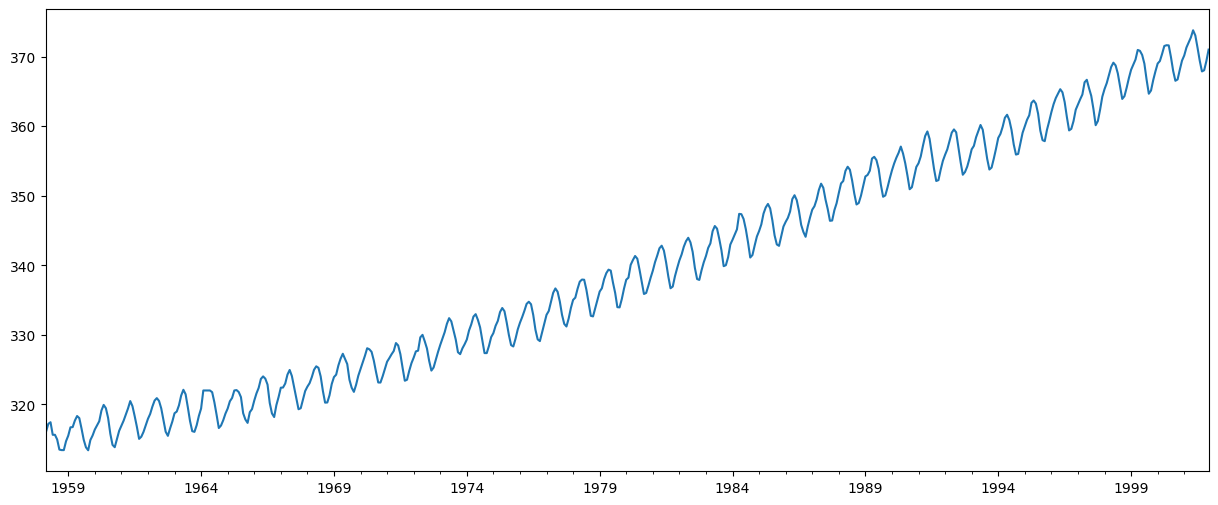

In [34]:
y.plot(figsize=(15, 6))
plt.show()

In [35]:
# 1958 - 1997 train set.
train = y[:'1997-12-01']
len(train)  # 478 months

478

In [36]:
# 1998 - 2001 test set.
test = y['1998-01-01':]
len(test)  # 48 months

48

In [37]:
#Dickey-Fuller Testi
def is_stationary(y):

    # "HO: Non-stationary"
    # "H1: Stationary"

    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        print(F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        print(F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")

In [38]:
is_stationary(y)

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


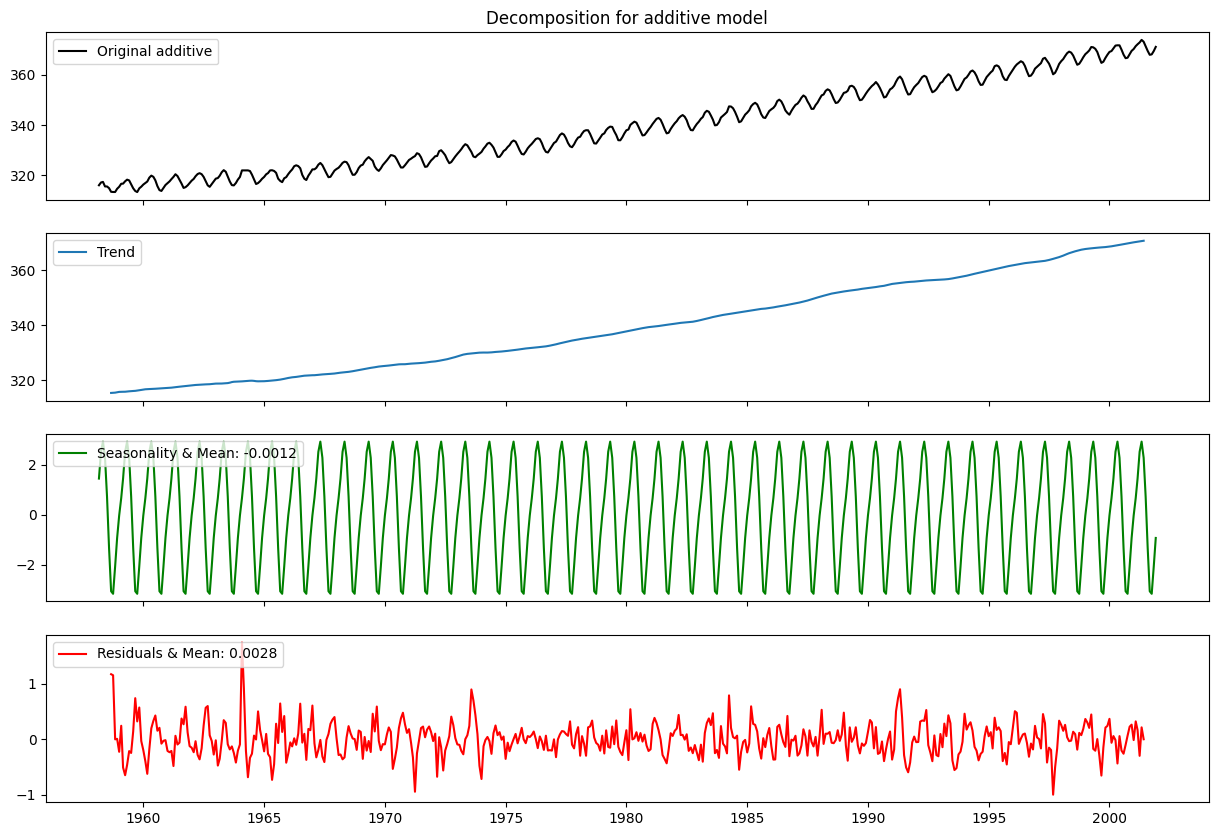

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


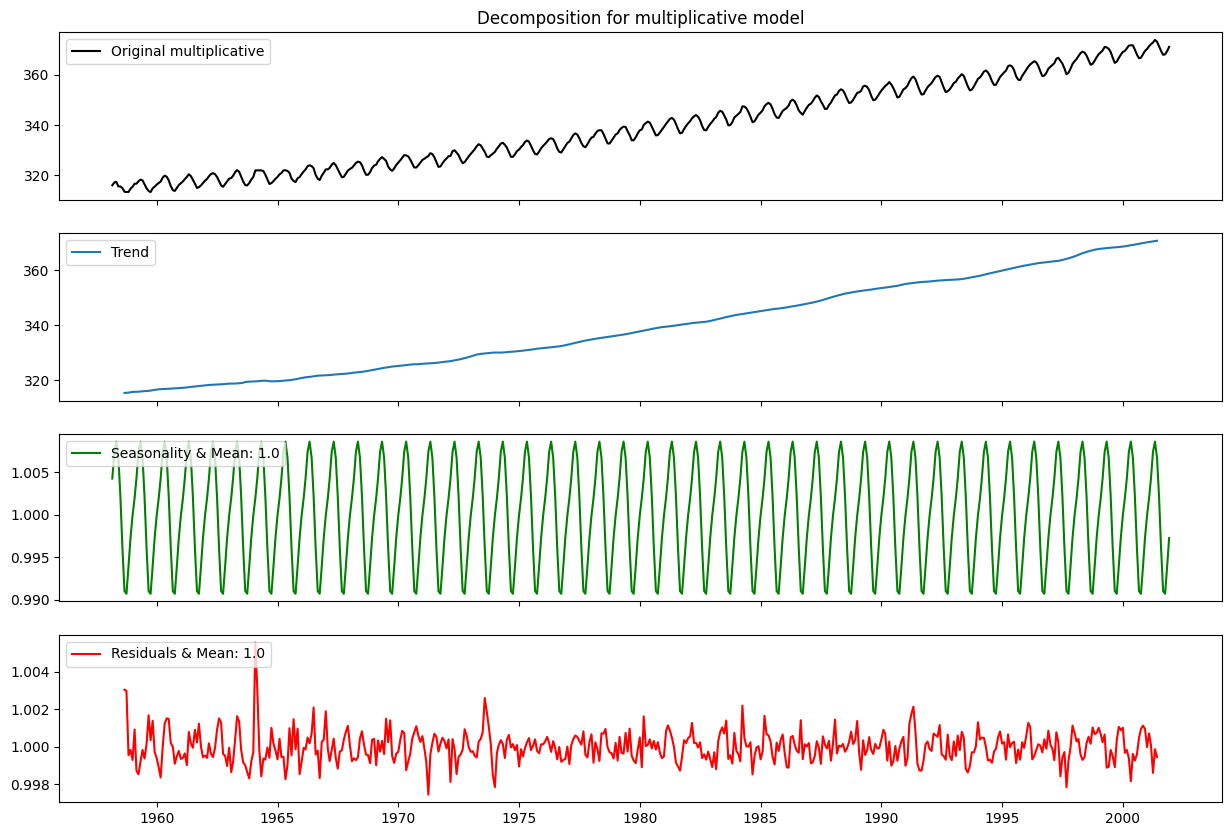

Result: Non-Stationary (H0: non-stationary, p-value: 0.999)


In [39]:
def ts_decompose(y, model="additive", stationary=False):
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

    if stationary:
        is_stationary(y)

# Toplamsal ve çarpımsal modeller için analiz
for model in ["additive", "multiplicative"]:
    ts_decompose(y, model, stationary=True)

In [40]:
# Single Exponential Smoothing
# SES = Level
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(48)


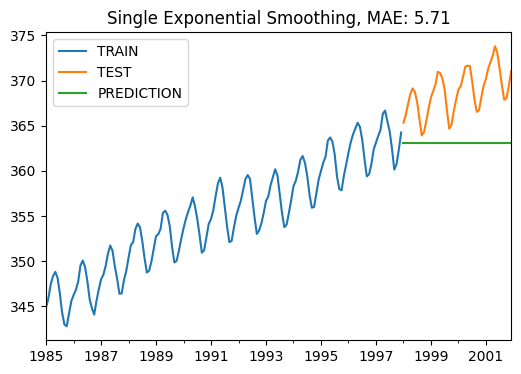

In [41]:
def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [42]:
# Hyperparameter Optimization

def ses_optimizer(train, alphas, step=48):
    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.8, 1, 0.01)
ses_optimizer(train, alphas)

best_alpha, best_mae = ses_optimizer(train, alphas)

alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.99 best_mae: 4.5451
alpha: 0.8 mae: 4.953
alpha: 0.81 mae: 4.9282
alpha: 0.82 mae: 4.9035
alpha: 0.83 mae: 4.8792
alpha: 0.84 mae: 4.8551
alpha: 0.85 mae: 4.8316
alpha: 0.86 mae: 4.8091
alpha: 0.87 mae: 4.7869
alpha: 0.88 mae: 4.765
alpha: 0.89 mae: 4.7434
alpha: 0.9 mae: 4.7221
alpha: 0.91 mae: 4.7012
alpha: 0.92 mae: 4.6805
alpha: 0.93 mae: 4.6602
alpha: 0.94 mae: 4.6402
alpha: 0.95 mae: 4.6205
alpha: 0.96 mae: 4.6012
alpha: 0.97 mae: 4.5822
alpha: 0.98 mae: 4.5634
alpha: 0.99 mae: 4.5451
best_alpha: 0.

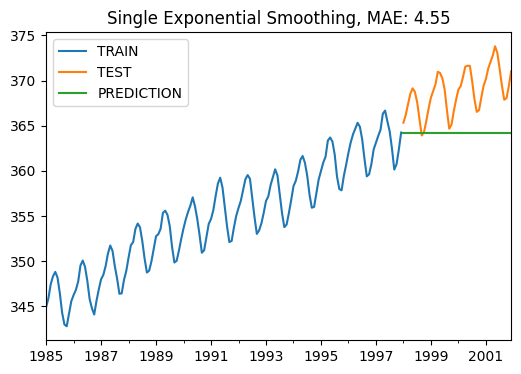

In [43]:
# Final SES Model
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(48)

plot_co2(train, test, y_pred, "Single Exponential Smoothing")

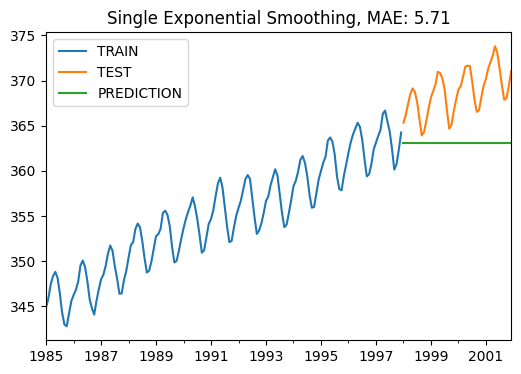

In [44]:
# Double Exponential Smoothing (DES)
# DES: Level (SES) + Trend
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=0.5)

y_pred = ses_model.forecast(48)

mean_absolute_error(test, y_pred)

def plot_co2(train, test, y_pred, title):
    mae = mean_absolute_error(test, y_pred)
    train["1985":].plot(legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae,2)}")
    test.plot(legend=True, label="TEST", figsize=(6, 4))
    y_pred.plot(legend=True, label="PREDICTION")
    plt.show()


plot_co2(train, test, y_pred, "Single Exponential Smoothing")

In [48]:
# Hyperparameter Optimization
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha,
                                                                     smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

In [50]:
alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas)

alpha: 0.01 beta: 0.01 mae: 2.3849
alpha: 0.01 beta: 0.11 mae: 2.8294
alpha: 0.01 beta: 0.21 mae: 2.744
alpha: 0.01 beta: 0.31 mae: 2.1723
alpha: 0.01 beta: 0.41 mae: 2.8895
alpha: 0.01 beta: 0.51 mae: 2.49
alpha: 0.01 beta: 0.61 mae: 1.8196
alpha: 0.01 beta: 0.71 mae: 1.7411
alpha: 0.01 beta: 0.81 mae: 2.1932
alpha: 0.01 beta: 0.91 mae: 4.8521
alpha: 0.11 beta: 0.01 mae: 2.4334
alpha: 0.11 beta: 0.11 mae: 3.9118
alpha: 0.11 beta: 0.21 mae: 6.0908
alpha: 0.11 beta: 0.31 mae: 7.2434
alpha: 0.11 beta: 0.41 mae: 8.7305
alpha: 0.11 beta: 0.51 mae: 10.3166
alpha: 0.11 beta: 0.61 mae: 12.0066
alpha: 0.11 beta: 0.71 mae: 13.9772
alpha: 0.11 beta: 0.81 mae: 16.4873
alpha: 0.11 beta: 0.91 mae: 19.655
alpha: 0.21 beta: 0.01 mae: 2.8218
alpha: 0.21 beta: 0.11 mae: 5.7217
alpha: 0.21 beta: 0.21 mae: 8.6538
alpha: 0.21 beta: 0.31 mae: 11.7598
alpha: 0.21 beta: 0.41 mae: 15.5277
alpha: 0.21 beta: 0.51 mae: 20.1474
alpha: 0.21 beta: 0.61 mae: 25.5273
alpha: 0.21 beta: 0.71 mae: 31.2781
alpha: 0.21 be

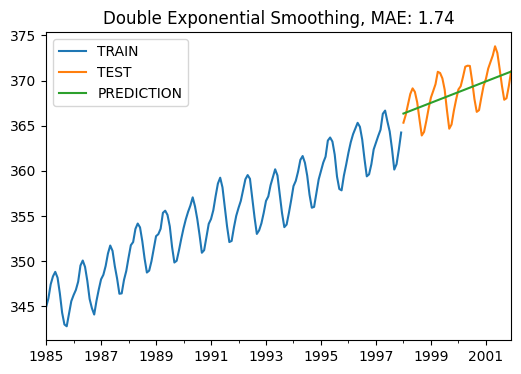

In [51]:
# Final DES Model
final_des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                               smoothing_slope=best_beta)
y_pred = final_des_model.forecast(48)

plot_co2(train, test, y_pred, "Double Exponential Smoothing")

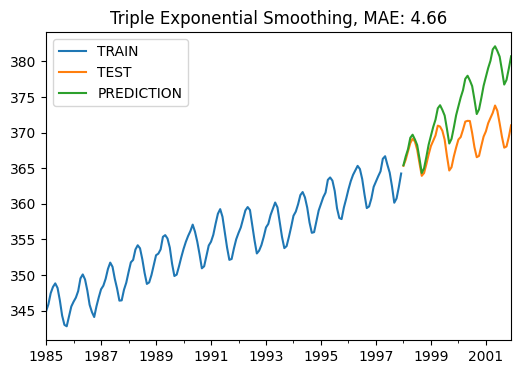

In [54]:
# Triple Exponential Smoothing (Holt-Winters)
# TES = SES + DES + Seasonality
tes_model = ExponentialSmoothing(train,
                                 trend="add",
                                 seasonal="add",
                                 seasonal_periods=12).fit(smoothing_level=0.5,
                                                          smoothing_slope=0.5,
                                                          smoothing_seasonal=0.5)
y_pred = tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")

In [56]:
# Hyperparameter Optimization
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")

    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

In [57]:
alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg)

[0.1, 0.1, 0.1, 1.5]
[0.1, 0.1, 0.3, 1.51]
[0.1, 0.1, 0.5, 1.55]
[0.1, 0.1, 0.7, 1.57]
[0.1, 0.1, 0.9, 1.59]
[0.1, 0.3, 0.1, 1.87]
[0.1, 0.3, 0.3, 1.67]
[0.1, 0.3, 0.5, 1.6]
[0.1, 0.3, 0.7, 1.51]
[0.1, 0.3, 0.9, 1.41]
[0.1, 0.5, 0.1, 0.86]
[0.1, 0.5, 0.3, 0.75]
[0.1, 0.5, 0.5, 0.79]
[0.1, 0.5, 0.7, 0.79]
[0.1, 0.5, 0.9, 0.71]
[0.1, 0.7, 0.1, 1.4]
[0.1, 0.7, 0.3, 1.68]
[0.1, 0.7, 0.5, 1.4]
[0.1, 0.7, 0.7, 3.24]
[0.1, 0.7, 0.9, 4.72]
[0.1, 0.9, 0.1, 2.32]
[0.1, 0.9, 0.3, 2.26]
[0.1, 0.9, 0.5, 2.69]
[0.1, 0.9, 0.7, 2.48]
[0.1, 0.9, 0.9, 4.56]
[0.3, 0.1, 0.1, 1.01]
[0.3, 0.1, 0.3, 0.78]
[0.3, 0.1, 0.5, 0.73]
[0.3, 0.1, 0.7, 0.79]
[0.3, 0.1, 0.9, 0.61]
[0.3, 0.3, 0.1, 1.38]
[0.3, 0.3, 0.3, 1.98]
[0.3, 0.3, 0.5, 1.39]
[0.3, 0.3, 0.7, 0.78]
[0.3, 0.3, 0.9, 1.36]
[0.3, 0.5, 0.1, 2.87]
[0.3, 0.5, 0.3, 6.57]
[0.3, 0.5, 0.5, 4.77]
[0.3, 0.5, 0.7, 2.38]
[0.3, 0.5, 0.9, 1053.58]
[0.3, 0.7, 0.1, 4.04]
[0.3, 0.7, 0.3, 4.51]
[0.3, 0.7, 0.5, 5.45]
[0.3, 0.7, 0.7, 687638504008.06]
[0.3, 0.7, 0.9, 3.6637

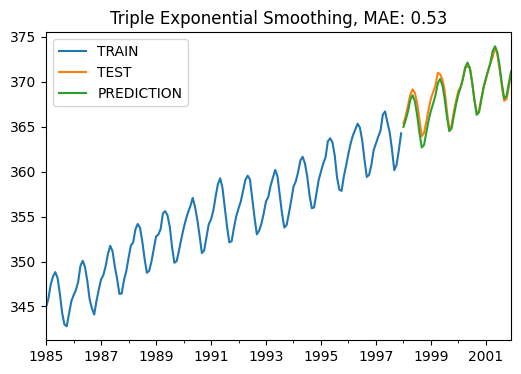

In [58]:
# Final TES Model

final_tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = final_tes_model.forecast(48)

plot_co2(train, test, y_pred, "Triple Exponential Smoothing")